# Bernstein - Vazirani Problem

This is a simple probelm that can be solved more efficiently in a quantum computer than in a a classical computer. A misterious $n$-bit string is given in an oracle. Let's call it $b$. The oracle computes $f(s) = b \cdot s \text{ (mod } 2)$. The problem is to find $b$ with the minimum possible number of calls to the oracle.

A classical algorithm requires at least $n$ calls to the oracle. On the contrary, using **quantum parallelism**, a quantum algorithm only requires 1 call. This notebook illustrates the implementaion of this magical algorithm.

In [ ]:
! pip install qiskit

The following cell includes all the imports necessary to execute the algorithm using Qiskit, and visualizing the results.

**IMPORTANT:** Keep in mind that Qiskit numerates qbits from right to left. Therefore, most significant bit is the last in numeration.

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer
from qiskit.visualization import plot_histogram
import random as rd

## Definition of the Oracle

Remember that the oracle is a gate that computes a $f:\{0,1\}^n \rightarrow \{0,1\}$ that corresponds to

$$f(s) = b \cdot s \text{ (mod } 2)$$

For some unknown $n$-bit string $b$. To simulate this situation, the following function generates a random $n$-bit string, and uses **CNOT** (reversible **XOR**) gates, to compute bitwise inner product.

In [ ]:
def VaziraniOracle(circ,nbits):
  # Generate random n-bit string
  mystr = [rd.randint(0,1) for idx in range(nbits)]
  # Build oracle
  for idx in range(nbits):
    if mystr[idx] == 1:
      # Then include bit of input on sum
      circ.cx(idx,nbits)
  # Return reversed string due to qiskit ordering of bits
  return reversed(mystr)

## Induce Quantum Parallelism

The first ingredient on any quantum parallel application is a **Hadamard Transform**, most of the times. It is defined as

$$H^{\otimes n} |x\rangle = \frac{1}{2^{n/2}}\sum_{z}(-1)^{z \cdot x} |z\rangle$$

Where $x \cdot z$ denotes *bitwise inner product*. By linearity, application of the oracle to this superposition state would yield "immediate" evaluation of oracle function at all $n$-bit strings. Hadmard transform is computed on the following cell.

In [ ]:
def Hadamard(circ,nbits):
  # Produce hadamard transform of first nbits
  for idx in range(nbits):
    circ.h(idx)

## Rounding Up the Algorithm

As explained in the notes, initializing the output qbit to $|-\rangle$ state pushes function evaluation as a phase (something known as *phase kickback*). In this way, the only possible outcome on the input register after quering the oracle, is the *misterious string*. The cell bellow implements the Bernstain-Vazirani algorithm.

**IMPORTANT:** Please read carefully the notes included in this repo to fully understand the mathematical details.

In [ ]:
def BernsteinVazirani(nbits):
  # Create register for inputs
  q_in = QuantumRegister(nbits,name='q_in')
  # Create register for function output
  q_out = QuantumRegister(1,name='q_out')
  # Create register for measuring random string of Vazirani Oracle
  c_str = ClassicalRegister(nbits,name='c_str')
  # Create quantum circuit
  qc_vazirani = QuantumCircuit(q_in,q_out,c_str)

  # Initialise output register to |-> for codifying function evaluation as phase difference
  qc_vazirani.x(nbits)
  qc_vazirani.h(nbits)
  qc_vazirani.barrier()
  # Profit parallelism using Hadamard transform
  Hadamard(qc_vazirani,nbits)
  qc_vazirani.barrier()
  # Call Vazirani Oracle
  mystr = VaziraniOracle(qc_vazirani,nbits)
  qc_vazirani.barrier()
  # Apply inverse Hadamard transform to recover randon string of Vazirani oracle
  Hadamard(qc_vazirani,nbits)
  qc_vazirani.barrier()
  # Measure to string classical register
  for idx in range(nbits):
    qc_vazirani.measure(idx,idx)
  
  return qc_vazirani, mystr

## Let's play with Qiskit

Change the number of bits that encode the misterious string in the cell bellow.

In [ ]:
nbits = 4

Run the following cell to see the quantum circuit and the misterious string.

In [ ]:
qc_vazirani, mystr = BernsteinVazirani(nbits)
mystr = [x for x in mystr]
print(mystr)
qc_vazirani.draw()

[0, 1, 0, 1]


░ ┌───┐ ░            ░ ┌───┐ ░ ┌─┐         
 q_in_0: ───────────░─┤ H ├─░───■────────░─┤ H ├─░─┤M├─────────
                    ░ ├───┤ ░   │        ░ ├───┤ ░ └╥┘┌─┐      
 q_in_1: ───────────░─┤ H ├─░───┼────────░─┤ H ├─░──╫─┤M├──────
                    ░ ├───┤ ░   │        ░ ├───┤ ░  ║ └╥┘┌─┐   
 q_in_2: ───────────░─┤ H ├─░───┼────■───░─┤ H ├─░──╫──╫─┤M├───
                    ░ ├───┤ ░   │    │   ░ ├───┤ ░  ║  ║ └╥┘┌─┐
 q_in_3: ───────────░─┤ H ├─░───┼────┼───░─┤ H ├─░──╫──╫──╫─┤M├
         ┌───┐┌───┐ ░ └───┘ ░ ┌─┴─┐┌─┴─┐ ░ └───┘ ░  ║  ║  ║ └╥┘
q_out_0: ┤ X ├┤ H ├─░───────░─┤ X ├┤ X ├─░───────░──╫──╫──╫──╫─
         └───┘└───┘ ░       ░ └───┘└───┘ ░       ░  ║  ║  ║  ║ 
c_str: 4/═══════════════════════════════════════════╩══╩══╩══╩═
                                                    0  1  2  3

**IMPORTANT:** If you want to execute this code on an IBMQ device, make sure to activte your IBM Token, and change the backend accordingly. Do not do this on a could-based computing resource unless it is adequately protected!

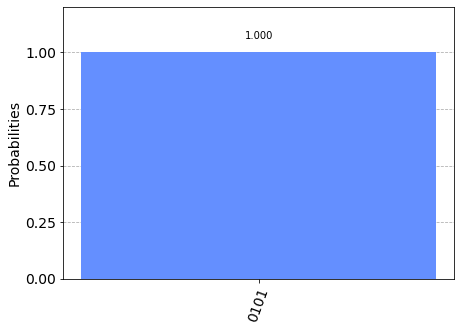

In [ ]:
backend = Aer.get_backend('qasm_simulator')
counts = execute(qc_vazirani,backend=backend).result().get_counts()
plot_histogram(counts)